## DeepMind's AlphaZero Algorithm on Connect 4

<img src="https://i.imgur.com/ZKo8vb2.png" 
     align="right" 
     width="400" />
     
### Objective
The aim of this notebook is to implement and train an AlphaZero agent on the game of Connect 4. AlphaZero represents a generic version of the AlphaGo Zero algorithm, renowned for achieving superhuman performance in Go, Chess, and Shogi solely through self-play, without any human generated data. We aim to explore how well AlphaZero can adapt and optimize its gameplay in the context of Connect 4.

### Methodology
1. **Game engine**: Implement a Connect 4 game engine to facilitate the interaction of the AlphaZero agent with the game environment.
2. **Neural network**: Design a deep neural network model to approximate both policy (best moves) and value (winning chances) functions.
3. **Self-play**: Utilize Monte Carlo tree search guided by the neural network to generate self-play data. The agent plays against itself to explore the game tree.
4. **Training**: Update the neural network weights based on the outcomes and search probabilities obtained during self-play.
5. **Evaluation**: Evaluate the trained neural network's ability to recognize critical game states, such as immediate wins or blocks as a performance heuristic.

The original AlphaZero paper can be viewed [here](https://arxiv.org/abs/1712.01815).

### Imports and Configuration

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import math
import random
import numpy as np
from scipy.signal import convolve2d
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from IPython.display import HTML
from base64 import b64encode


config_dict = {
    'device': torch.device('cuda') if torch.cuda.is_available() else 'cpu',
    'n_filters': 128,              # Number of convolutional filters used in residual blocks
    'n_res_blocks': 8,             # Number of residual blocks used in network
    'exploration_constant': 2,     # Exploration constant used in PUCT calculation
    'temperature': 1.25,           # Selection temperature. A greater temperature is a more uniform distribution
    'dirichlet_alpha': 1.,         # Alpha parameter for Dirichlet noise. Larger values mean more uniform noise
    'dirichlet_eps': 0.25,         # Weight of dirichlet noise
    'learning_rate': 0.001,        # Adam learning rate
    'training_epochs': 50,         # How many full training epochs
    'games_per_epoch': 100,        # How many self-played games per epoch
    'minibatch_size': 128,         # Size of each minibatch used in learning update 
    'n_minibatches': 4,            # How many minibatches to accumulate per learning step
    'mcts_start_search_iter': 30,  # Number of Monte Carlo tree search iterations initially
    'mcts_max_search_iter': 150,   # Maximum number of MCTS iterations
    'mcts_search_increment': 1,    # After each epoch, how much should search iterations be increased by
    }

# Convert to a struct esque object
class Config:
    def __init__(self, dictionary):
        for key, value in dictionary.items():
            setattr(self, key, value)

config = Config(config_dict)

### Connect 4 Game Logic
This class, `Connect4``, serves as the game engine for Connect 4. It defines the rules, board configurations, and state transitions. The board is modeled as a 6x7 grid, and the class offers various methods for game-related tasks.

Array data structures are used heavily for efficient computation.


In [2]:
class Connect4:
    "Connect 4 game engine, containing methods for game-related tasks."
    def __init__(self):
        self.rows = 6
        self.cols = 7

    def get_next_state(self, state, action, to_play=1):
        "Play an action in a given state and return the resulting board."
        # Pre-condition checks
        assert self.evaluate(state) == 0
        assert np.sum(abs(state)) != self.rows * self.cols
        assert action in self.get_valid_actions(state)
        
        # Identify next empty row in column
        row = np.where(state[:, action] == 0)[0][-1]
        
        # Apply action
        new_state = state.copy()
        new_state[row, action] = to_play
        return new_state

    def get_valid_actions(self, state):
        "Return a numpy array containing the indices of valid actions."
        # If game over, no valid moves
        if self.evaluate(state) != 0:
            return np.array([])
        
        # Identify valid columns to play
        cols = np.sum(np.abs(state), axis=0)
        return np.where((cols // self.rows) == 0)[0]

    def evaluate(self, state):
        "Evaluate the current position. Returns 1 for player 1 win, -1 for player 2 and 0 otherwise."
        # Kernels for checking win conditions
        kernel = np.ones((1, 4), dtype=int)
        
        # Horizontal and vertical checks
        horizontal_check = convolve2d(state, kernel, mode='valid')
        vertical_check = convolve2d(state, kernel.T, mode='valid')

        # Diagonal checks
        diagonal_kernel = np.eye(4, dtype=int)
        main_diagonal_check = convolve2d(state, diagonal_kernel, mode='valid')
        anti_diagonal_check = convolve2d(state, np.fliplr(diagonal_kernel), mode='valid')
        
        # Check for winner
        if any(cond.any() for cond in [horizontal_check == 4, vertical_check == 4, main_diagonal_check == 4, anti_diagonal_check == 4]):
            return 1
        elif any(cond.any() for cond in [horizontal_check == -4, vertical_check == -4, main_diagonal_check == -4, anti_diagonal_check == -4]):
            return -1

        # No winner
        return 0  

    def step(self, state, action, to_play=1):
        "Play an action in a given state. Return the next_state, reward and done flag."
        # Get new state and reward
        next_state = self.get_next_state(state, action, to_play)
        reward = self.evaluate(next_state)
        
        # Check for game termination
        done = True if reward != 0 or np.sum(abs(next_state)) >= (self.rows * self.cols - 1) else False
        return next_state, reward, done

    def encode_state(self, state):
        "Convert state to tensor with 3 channels."
        encoded_state = np.stack((state == 1, state == 0, state == -1)).astype(np.float32)
        if len(state.shape) == 3:
            encoded_state = np.swapaxes(encoded_state, 0, 1)
        return encoded_state

    def reset(self):
        "Reset the board."
        return np.zeros([self.rows, self.cols], dtype=np.int8)

### The Residual Neural Network
The code defines the architecture for a residual neural network (ResNet) that serves as the core of the AlphaZero algorithm applied to Connect 4. ResNets are known for their ability to learn from the addition of residual (or "skip") connections, mitigating the vanishing gradient problem in deep networks [He et al. 2015](https://arxiv.org/abs/1512.03385).

In the context of AlphaZero, this ResNet is designed with two distinct heads branching from the common convolutional base:

1. **Policy head**: Outputs a probability distribution over possible actions, guiding the agent on which column to drop the disc in during gameplay.
2. **Value Head**: Produces a scalar value within the range [-1, 1] that approximates the value of the current board state, aiding in evaluating the board's win-lose potential.

The network accepts a three-channeled representation of the board. These channels capture three aspects of the game state: the positions of the player's discs, the opponent's discs, and empty space, making it easier for the network to discriminate and process the board information.

ResNets are particularly effective for board games like Connect 4 because they're good at understanding the layout and spatial relationships on the board. The residual connections help the network better pass along this spatial information through its layers.

In [3]:
class ResNet(nn.Module):
    "Complete residual neural network model."
    def __init__(self, game, config):
        super().__init__()

        # Board dimensions
        self.board_size = (game.rows, game.cols)
        n_actions = game.cols  # Number of columns represent possible actions
        n_filters = config.n_filters
        
        self.base = ConvBase(config)  # Base layers

        # Policy head for choosing actions
        self.policy_head = nn.Sequential(
            nn.Conv2d(n_filters, n_filters//4, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters//4),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(n_filters//4 * self.board_size[0] * self.board_size[1], n_actions)
        )

        # Value head for evaluating board states
        self.value_head = nn.Sequential(
            nn.Conv2d(n_filters, n_filters//32, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters//32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(n_filters//32 * self.board_size[0] * self.board_size[1], 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.base(x) 
        x_value = self.value_head(x)
        x_policy = self.policy_head(x)
        return x_value, x_policy

class ConvBase(nn.Module):
    "Convolutional base for the network."
    def __init__(self, config):
        super().__init__()
        
        n_filters = config.n_filters
        n_res_blocks = config.n_res_blocks

        # Initial convolutional layer
        self.conv = nn.Sequential(
            nn.Conv2d(3, n_filters, kernel_size=3, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        )

        # List of residual blocks
        self.res_blocks = nn.ModuleList(
            [ResidualBlock(n_filters) for _ in range(n_res_blocks)]
        )

    def forward(self, x):
        x = self.conv(x)
        for block in self.res_blocks:
            x = block(x)
        return x

class ResidualBlock(nn.Module):
    "Residual block, the backbone of a ResNet."
    def __init__(self, n_filters):
        super().__init__()

        # Two convolutional layers, both with batch normalization
        self.conv_1 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.batch_norm_1 = nn.BatchNorm2d(n_filters)
        self.conv_2 = nn.Conv2d(n_filters, n_filters, kernel_size=3, padding=1)
        self.batch_norm_2 = nn.BatchNorm2d(n_filters)
        self.relu = nn.ReLU()

    def forward(self, x):
        # Pass x through layers and add skip connection
        output = self.relu(self.batch_norm_1(self.conv_1(x)))
        output = self.batch_norm_2(self.conv_2(output))
        return self.relu(output + x)

### Monte Carlo Tree Search in AlphaZero
Monte Carlo Tree Search (MCTS) is a search algorithm widely used in board games for making decisions. Vanilla MCTS uses random rollouts to estimate the value of each state, which is computationally expensive and often inaccurate without a very large number of samples.

#### Limitations of Vanilla MCTS
- **Inaccurate approximations**: The vanilla version approximates the value of a state based on random rollouts, which can be a poor approximation especially in complex game spaces.
- **Computational expense**: The number of rollouts needed for an accurate approximation can be exceedingly large, making it computationally expensive.

#### AlphaZero's Modifications
- **Neural network evaluation**: Instead of relying on rollouts, AlphaZero uses a neural network to approximate both the state-value and the policy (action probabilities), making the search both more directed and efficient.
- **Dirichlet noise**: AlphaZero adds Dirichlet noise to the prior probabilities of the root node to encourage exploration of less visited nodes.
- **PUCT score**: Classic MCTS uses UCB (Upper Confidence Bound) for tree traversal. AlphaZero uses a modified version called PUCT (Polynomial Upper Confidence Trees), which balances exploration and exploitation more effectively.

By addressing the limitations of traditional MCTS and integrating a neural network approximation function, AlphaZero significantly improves both the efficiency and accuracy of the tree search algorithm.

In [4]:
class MCTS:
    def __init__(self, network, game, config):
        "Initialize Monte Carlo Tree Search with a given neural network, game instance, and configuration."
        self.network = network
        self.game = game
        self.config = config

    def search(self, state, total_iterations, temperature=None):
        "Performs a search for the desired number of iterations, returns an action and the tree root."
        # Create the root
        root = Node(None, state, 1, self.game, self.config)

        # Expand the root, adding noise to each action
        # Get valid actions
        valid_actions = self.game.get_valid_actions(state)
        state_tensor = torch.tensor(self.game.encode_state(state), dtype=torch.float).unsqueeze(0).to(self.config.device)
        with torch.no_grad():
            self.network.eval()
            value, logits = self.network(state_tensor)

        # Get action probabilities
        action_probs = F.softmax(logits.view(self.game.cols), dim=0).cpu().numpy()

        # Calculate and add dirichlet noise
        noise = np.random.dirichlet([self.config.dirichlet_alpha] * self.game.cols)
        action_probs = ((1 - self.config.dirichlet_eps) * action_probs) + self.config.dirichlet_eps * noise

        # Mask unavailable actions
        mask = np.full(self.game.cols, False)
        mask[valid_actions] = True
        action_probs = action_probs[mask]

        # Softmax
        action_probs /= np.sum(action_probs)

        # Create a child for each possible action
        for action, prob in zip(valid_actions, action_probs):
            child_state = -self.game.get_next_state(state, action)
            root.children[action] = Node(root, child_state, -1, self.game, self.config)
            root.children[action].prob = prob

        # Since we're not backpropagating, manually increase visits
        root.n_visits = 1
        # Set value as neural network prediction also as it will slightly improve the accuracy of the value target later
        root.total_score = value.item()

        # Begin search
        for _ in range(total_iterations):
            current_node = root

            # Phase 1: Selection
            # While not currently on a leaf node, select a new node using PUCT score
            while not current_node.is_leaf():
                current_node = current_node.select_child()

            # Phase 2: Expansion
            # When a leaf node is reached and it's not terminal; expand it
            if not current_node.is_terminal():
                current_node.expand()
                # Convert node state to tensor and pass through network
                state_tensor = torch.tensor(self.game.encode_state(current_node.state), dtype=torch.float).unsqueeze(0).to(self.config.device)
                with torch.no_grad():
                    self.network.eval()
                    value, logits = self.network(state_tensor)
                    value = value.item()

                # Mask invalid actions, then calculate masked action probs
                mask = np.full(self.game.cols, False)
                mask[valid_actions] = True
                action_probs = F.softmax(logits.view(self.game.cols)[mask], dim=0).cpu().numpy()
                for child, prob in zip(current_node.children.values(), action_probs):
                    child.prob = prob
            # If node is terminal, get the value of it from game instance
            else:
                value = self.game.evaluate(current_node.state)

            # Phase 3: Backpropagation
            # Backpropagate the value of the leaf to the root
            current_node.backpropagate(value)
        
        # Select action with specified temperature
        if temperature == None:
            temperature = self.config.temperature
        return self.select_action(root, temperature), root

    def select_action(self, root, temperature=None):
        "Select an action from the root based on visit counts, adjusted by temperature, 0 temp for greedy."
        if temperature == None:
            temperature = self.config.temperature
        action_counts = {key: val.n_visits for key, val in root.children.items()}
        if temperature == 0:
            return max(action_counts, key=action_counts.get)
        elif temperature == np.inf:
            return np.random.choice(list(action_counts.keys()))
        else:
            distribution = np.array([*action_counts.values()]) ** (1 / temperature)
            return np.random.choice([*action_counts.keys()], p=distribution/sum(distribution))

class Node:
    def __init__(self, parent, state, to_play, game, config):
        "Represents a node in the MCTS, holding the game state and statistics for MCTS to operate."
        self.parent = parent
        self.state = state
        self.to_play = to_play
        self.config = config
        self.game = game

        self.prob = 0
        self.children = {}
        self.n_visits = 0
        self.total_score = 0

    def expand(self):
        "Create child nodes for all valid actions. If state is terminal, evaluate and set the node's value."
        # Get valid actions
        valid_actions = self.game.get_valid_actions(self.state)

        # If there are no valid actions, state is terminal, so get value using game instance
        if len(valid_actions) == 0:
            self.total_score = self.game.evaluate(self.state)
            return

        # Create a child for each possible action
        for action in zip(valid_actions):
            # Make move, then flip board to perspective of next player
            child_state = -self.game.get_next_state(self.state, action)
            self.children[action] = Node(self, child_state, -self.to_play, self.game, self.config)

    def select_child(self):
        "Select the child node with the highest PUCT score."
        best_puct = -np.inf
        best_child = None
        for child in self.children.values():
            puct = self.calculate_puct(child)
            if puct > best_puct:
                best_puct = puct
                best_child = child
        return best_child

    def calculate_puct(self, child):
        "Calculate the PUCT score for a given child node."
        # Scale Q(s,a) so it's between 0 and 1 so it's comparable to a probability
        # Using 1 - Q(s,a) because it's from the perspectve of the child – the opposite of the parent
        exploitation_term = 1 - (child.get_value() + 1) / 2
        exploration_term = child.prob * math.sqrt(self.n_visits) / (child.n_visits + 1)
        return exploitation_term + self.config.exploration_constant * exploration_term

    def backpropagate(self, value):
        "Update the current node and its ancestors with the given value."
        self.total_score += value
        self.n_visits += 1
        if self.parent is not None:
            # Backpropagate the negative value so it switches each level
            self.parent.backpropagate(-value)

    def is_leaf(self):
        "Check if the node is a leaf (no children)."
        return len(self.children) == 0

    def is_terminal(self):
        "Check if the node represents a terminal state."
        return (self.n_visits != 0) and (len(self.children) == 0)

    def get_value(self):
        "Calculate the average value of this node."
        if self.n_visits == 0:
            return 0
        return self.total_score / self.n_visits
    
    def __str__(self):
        "Return a string containing the node's relevant information for debugging purposes."
        return (f"State:\n{self.state}\nProb: {self.prob}\nTo play: {self.to_play}" +
                f"\nNumber of children: {len(self.children)}\nNumber of visits: {self.n_visits}" +
                f"\nTotal score: {self.total_score}")

### AlphaZero Algorithm

This class `AlphaZero` encapsulates the core of the AlphaZero algorithm. It combines MCTS with a ResNet to play and learn autonomously. 

#### Components
- **Initialization**: Sets up the neural network, MCTS, and pre-allocates GPU memory for training.
- **Memory Management**: Utilizes pre-allocated memory on the GPU for efficient storage of training data.
- **Training loop**: Orchestrates self-play and learning over a specified number of epochs.
- **Self-play**: Executes one complete game, storing game states, values, and policies into memory.
- **Learning Step**: Performs several mini-batch learning steps, updating the neural network parameters.

In [5]:
class AlphaZero:
    def __init__(self, game, config, verbose=True):
        self.network = ResNet(game, config).to(config.device)
        self.mcts = MCTS(self.network, game, config)
        self.game = game
        self.config = config

        # Losses and optimizer
        self.loss_cross_entropy = nn.CrossEntropyLoss()
        self.loss_mse = nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.network.parameters(), lr=config.learning_rate, weight_decay=0.0001)

        # Pre-allocate memory on GPU
        state_shape = game.encode_state(game.reset()).shape
        self.max_memory = config.minibatch_size * config.n_minibatches
        self.state_memory = torch.zeros(self.max_memory, *state_shape).to(config.device)
        self.value_memory = torch.zeros(self.max_memory, 1).to(config.device)
        self.policy_memory = torch.zeros(self.max_memory, game.cols).to(config.device)
        self.current_memory_index = 0
        self.memory_full = False

        # MCTS search iterations
        self.search_iterations = config.mcts_start_search_iter
        
        # Logging
        self.verbose = verbose
        self.total_games = 0

    def train(self, training_epochs):
        "Train the AlphaZero agent for a specified number of training epochs."
        # For each training epoch
        for _ in range(training_epochs):

            # Play specified number of games
            for _ in range(self.config.games_per_epoch):
                self.self_play()
            
            # At the end of each epoch, increase the number of MCTS search iterations
            self.search_iterations = min(self.config.mcts_max_search_iter, self.search_iterations + self.config.mcts_search_increment)

    def self_play(self):
        "Perform one episode of self-play."
        state = self.game.reset()
        done = False
        while not done:
            # Search for a move
            action, root = self.mcts.search(state, self.search_iterations)

            # Value target is the value of the MCTS root node
            value = root.get_value()

            # Visit counts used to compute policy target
            visits = np.zeros(self.game.cols)
            for child_action, child in root.children.items():
                visits[child_action] = child.n_visits
            # Softmax so distribution sums to 1
            visits /= np.sum(visits)

            # Append state + value & policy targets to memory
            self.append_to_memory(state, value, visits)

            # If memory is full, perform a learning step
            if self.memory_full:
                self.learn()

            # Perform action in game
            state, _, done = self.game.step(state, action)

            # Flip the board
            state = -state

        # Increment total games played
        self.total_games += 1

        # Logging if verbose
        if self.verbose:
            print("\rTotal Games:", self.total_games, "Items in Memory:", self.current_memory_index, "Search Iterations:", self.search_iterations, end="")

    def append_to_memory(self, state, value, visits):
        """
        Append state and MCTS results to memory buffers.
        Args:
            state (array-like): Current game state.
            value (float): MCTS value for the game state.
            visits (array-like): MCTS visit counts for available moves.
        """
        # Calculate the encoded states
        encoded_state = np.array(self.game.encode_state(state))
        encoded_state_augmented = np.array(self.game.encode_state(state[:, ::-1]))

        # Stack states and visits
        states_stack = np.stack((encoded_state, encoded_state_augmented), axis=0)
        visits_stack = np.stack((visits, visits[::-1]), axis=0)

        # Convert the stacks to tensors
        state_tensor = torch.tensor(states_stack, dtype=torch.float).to(self.config.device)
        visits_tensor = torch.tensor(visits_stack, dtype=torch.float).to(self.config.device)
        value_tensor = torch.tensor(np.array([value, value]), dtype=torch.float).to(self.config.device).unsqueeze(1)

        # Store in pre-allocated GPU memory
        self.state_memory[self.current_memory_index:self.current_memory_index + 2] = state_tensor
        self.value_memory[self.current_memory_index:self.current_memory_index + 2] = value_tensor
        self.policy_memory[self.current_memory_index:self.current_memory_index + 2] = visits_tensor

        # Increment index, handle overflow
        self.current_memory_index = (self.current_memory_index + 2) % self.max_memory

        # Set memory filled flag to True if memory is full
        if (self.current_memory_index == 0) or (self.current_memory_index == 1):
            self.memory_full = True


    def learn(self):
        "Update the neural network by extracting minibatches from memory and performing one step of optimization for each one."
        self.network.train()

        # Create a randomly shuffled list of batch indices
        batch_indices = np.arange(self.max_memory)
        np.random.shuffle(batch_indices)

        for batch_index in range(self.config.n_minibatches):
            # Get minibatch indices
            start = batch_index * self.config.minibatch_size
            end = start + self.config.minibatch_size
            mb_indices = batch_indices[start:end]

            # Slice memory tensors
            mb_states = self.state_memory[mb_indices]
            mb_value_targets = self.value_memory[mb_indices]
            mb_policy_targets = self.policy_memory[mb_indices]

            # Network predictions
            value_preds, policy_logits = self.network(mb_states)

            # Loss calculation
            policy_loss = self.loss_cross_entropy(policy_logits, mb_policy_targets)
            value_loss = self.loss_mse(value_preds.view(-1), mb_value_targets.view(-1))
            loss = policy_loss + value_loss

            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        self.memory_full = False
        self.network.eval()

### Evaluator
The purpose of the `Evaluator` class is to assess the neural network's ability to make obvious winning moves, such as winning or blocking an opponent's winning move. It integrates with an existing AlphaZero instance, inheriting its network, game logic, and configurations. Whilst not an effective means to evaluate high-level play, this class is helpful in establishing that an AlphaZero agent is learning.

#### Components
- **Initialization**: Takes an AlphaZero instance and prepares a set of example states and actions for evaluation.
- **Action selection**: Finds an action either to win the game immediately or to block the opponent from winning using simple game logic.
- **Example generation**: Constructs example sets for winning and blocking scenarios, subsequently encoding them for evaluation.
- **Evaluation**: Computes the accuracy of the neural network's predictions on the generated examples.

In [6]:
class Evaluator:
    "Class to evaluate the policy network's performance on simple moves."
    def __init__(self, alphazero, num_examples=500, verbose=True):
        self.network = alphazero.network
        self.game = alphazero.game
        self.config = alphazero.config
        self.accuracies = []
        self.num_examples = num_examples
        self.verbose = verbose

        # Generate and prepare example states and actions for evaluation
        self.generate_examples()

    def select_action(self, state):
        "Select an action based on the given state, will choose a winning or blocking moves."
        valid_actions = self.game.get_valid_actions(state)
        
        # Check for a winning move
        for action in valid_actions:
            next_state, reward, _ = self.game.step(state, action)
            if reward == 1:
                return action

        # Check for a blocking move
        flipped_state = -state
        for action in valid_actions:
            next_state, reward, _ = self.game.step(flipped_state, action)
            if reward == 1:
                return action

        # Default to random action if no winning or blocking move
        return random.choice(valid_actions)

    def generate_examples(self):
        "Generate and prepare example states and actions for evaluation."
        winning_examples = self.generate_examples_for_condition('win')
        blocking_examples = self.generate_examples_for_condition('block')

        # Prepare states and actions for evaluation
        winning_example_states, winning_example_actions = zip(*winning_examples)
        blocking_example_states, blocking_example_actions = zip(*blocking_examples)

        target_states = np.concatenate([winning_example_states, blocking_example_states], axis=0)
        target_actions = np.concatenate([winning_example_actions, blocking_example_actions], axis=0)

        encoded_states = [self.game.encode_state(state) for state in target_states]
        self.X_target = torch.tensor(np.stack(encoded_states, axis=0), dtype=torch.float).to(self.config.device)
        self.y_target = torch.tensor(target_actions, dtype=torch.long).to(self.config.device)

    def generate_examples_for_condition(self, condition):
        "Generate examples based on either 'win' or 'block' conditions."
        examples = []
        while len(examples) < self.num_examples:
            state = self.game.reset()
            while True:
                action = self.select_action(state)
                next_state, reward, done = self.game.step(state, action, to_play=1)
                
                if condition == 'win' and reward == 1:
                    examples.append((state, action))
                    break
                
                if done:
                    break
                
                state = next_state

                # Flipping the board for opponent's perspective
                action = self.select_action(-state)
                next_state, reward, done = self.game.step(state, action, to_play=-1)
                
                if condition == 'block' and reward == -1:
                    examples.append((-state, action))
                    break
                
                if done:
                    break
                
                state = next_state
        return examples

    def evaluate(self):
        "Evaluate the policy network's accuracy and append it to self.accuracies."
        with torch.no_grad():
            self.network.eval()
            _, logits = self.network(self.X_target)
            pred_actions = logits.argmax(dim=1)
            accuracy = (pred_actions == self.y_target).float().mean().item()
        
        self.accuracies.append(accuracy)
        if self.verbose:
            print(f"Initial Evaluation Accuracy: {100 * accuracy:.1f}%")

### Training and Evaluation Loop
This code orchestrates the training and evaluation process. The agent is trained for a single epoch, then evaluated.

In [7]:
game = Connect4()
alphazero = AlphaZero(game, config)
evaluator = Evaluator(alphazero)

# Evaluate pre training
evaluator.evaluate()

# Main training/eval loop
for _ in range(config.training_epochs):
    alphazero.train(1)
    evaluator.evaluate()

# Save trained weights
torch.save(alphazero.network.state_dict(), 'alphazero-network-weights.pth')

### Plotting Policy Performance During Training
The graph shows the performance improvement of the policy network over time. Bear in mind that the policy network only sees immediately available available moves; it doesn't use any tree search to look ahead. This means the performance shown is a gross underestimate compared to the actual gameplay where tree search is used. Nonetheless, it's a useful metric for tracking how the policy improves over time.

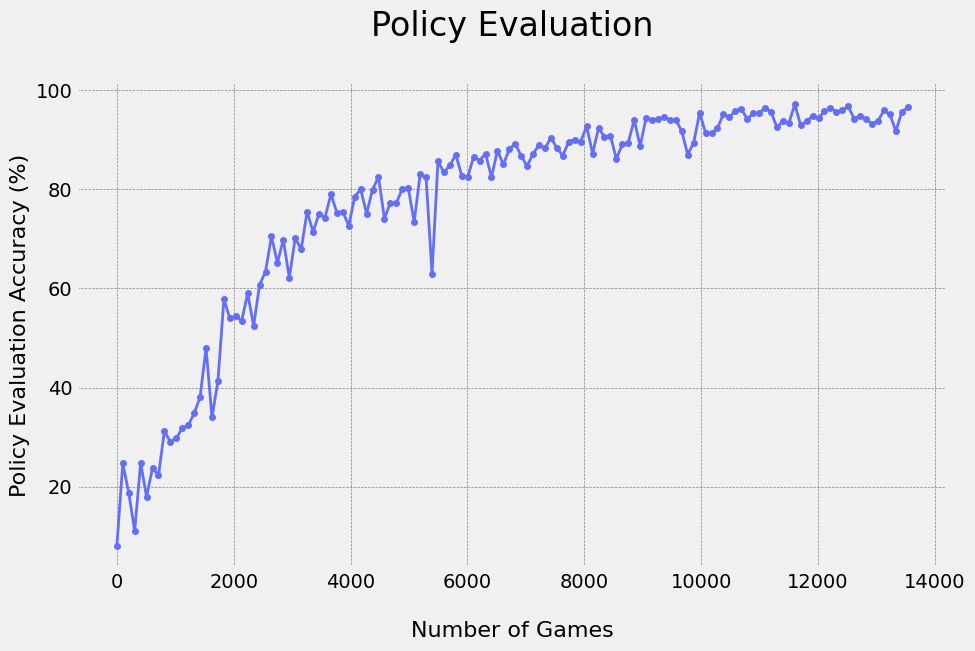

In [8]:
# Plot data
x_values = np.linspace(0, 101 * len(evaluator.accuracies), len(evaluator.accuracies))
y_values = [acc * 100 for acc in evaluator.accuracies]

# Create plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values, linewidth=2, marker='o', markersize=4, linestyle='-', color='#636EFA')

# Formatting
plt.xlabel('\nNumber of Games', fontsize=16)
plt.ylabel('Policy Evaluation Accuracy (%)', fontsize=16)
plt.title('Policy Evaluation\n', fontsize=24)
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')

plt.show()

### Play Against AlphaZero
The following code allows for a person to play vs AlphaZero. The number of search iterations can be adjusted as desired. A search depth of 0 will only utilize the policy network in decision making.

#### Load Pre-Trained Weights
In the case that you'd prefer not train the model yourself (I include myself in this group), you can load the neural network weights from a model I trained for about 24 hours on around 13,000 games. I will make these weights available on GitHub in the near future. Comment out these lines if you trained the model yourself.

In [9]:
file_path = "/kaggle/input/alphazero-model-and-video/alphazero-network-weights-130-epochs.pth"
pre_trained_weights = torch.load(file_path, map_location=config.device)

alphazero.network.load_state_dict(pre_trained_weights)

<All keys matched successfully>

### AlphaZero Agent
A simple class that intergrates with AlphaZero for move selection using Monte Carlo tree search to a specified depth.

In [10]:
class AlphaZeroAgent:
    def __init__(self, alphazero):
        self.alphazero = alphazero
        self.alphazero.network.eval()
        
        # Remove noise from move calculations
        self.alphazero.config.dirichlet_eps = 0

    def select_action(self, state, search_iterations=200):
        state_tensor = torch.tensor(self.alphazero.game.encode_state(state), dtype=torch.float).to(self.alphazero.config.device)
        
        # Get action without using search
        if search_iterations == 0:
            with torch.no_grad():
                _, logits = self.alphazero.network(state_tensor.unsqueeze(0))

            # Get action probs and mask for valid actions
            action_probs = F.softmax(logits.view(-1), dim=0).cpu().numpy()
            valid_actions = self.alphazero.game.get_valid_actions(state)
            valid_action_probs = action_probs[valid_actions]
            best_action = valid_actions[np.argmax(valid_action_probs)]
            return best_action
        # Else use MCTS 
        else:
            action, _ = self.alphazero.mcts.search(state, search_iterations)
            return action

### A Simple Game Playing Interface
Here a human can play a game of Connect 4 with AlphaZero.

In [11]:
agent = AlphaZeroAgent(alphazero)

# Set to 1 for AlphaZero to play first
turn = 0

# Reset the game
state = Connect4().reset()
done = False

# Play loop
while not done:
    print("Current Board:")
    print(state)

    if turn == 0:
        print("Human to move.")
        action = int(input("Enter a move:"))
    else:
        print("AlphaZero is thinking...")
        action = agent.select_action(state, 200)

    next_state, reward, done = Connect4().step(state, action)

    print("Board After Move:")
    print(next_state)

    if done == True:
        print("Game over")
    else:
        state = -next_state
        turn = 1 - turn

### Visualization of AlphaZero vs a High Level AI
Here we observe a Connect 4 game where our trained AlphaZero agent plays against a strong AI opponent that uses alpha-beta pruning for move selection. Alpha-beta pruning is an optimized version of the classic minimax tree search algorithm. 

The game was recorded using Bryan Braun's Connect Four tool, accessible here: https://www.bryanbraun.com/connect-four/

In [13]:
def play(filename):
    html = ""
    video = open(filename,"rb").read()
    src = "data:video/mp4;base64," + b64encode(video).decode()
    html += "<video width=800 controls autoplay loop><source src='%s' type='video/mp4'></video>" % src 
    return HTML(html)

play("/kaggle/input/alphazero-model-and-video/connect-4-recording.mp4")

### Finishing Remarks
Constructing AlphaZero from the ground up has been both challenging and gratifying. The neural network components were relatively straightforward to assemble, but the Monte Carlo tree search was very fiddly.

In comparison to other AlphaZero implementations on GitHub, I hope for this to be among the more readable and easy to understand.

For anyone else also building AlphaZero from scratch, I hope this serves as a helpful reference.